In [ ]:
import requests
import pandas as pd
from collections import defaultdict
import json
import numpy as np
import re
from tqdm import tqdm
import os

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### Train

In [ ]:
df = pd.read_csv("final_balanced_dataset.csv")
texts = df["sentence"].tolist()
labels = df["label"].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.282500,0.215005
2,0.100000,0.255253
3,0.034400,0.260392


TrainOutput(global_step=1500, training_loss=0.1389731127421061, metrics={'train_runtime': 601.1125, 'train_samples_per_second': 39.926, 'train_steps_per_second': 2.495, 'total_flos': 1578666332160000.0, 'train_loss': 0.1389731127421061, 'epoch': 3.0})

Accuracy: 0.952
F1: 0.951
Precision: 0.966
Recall: 0.935


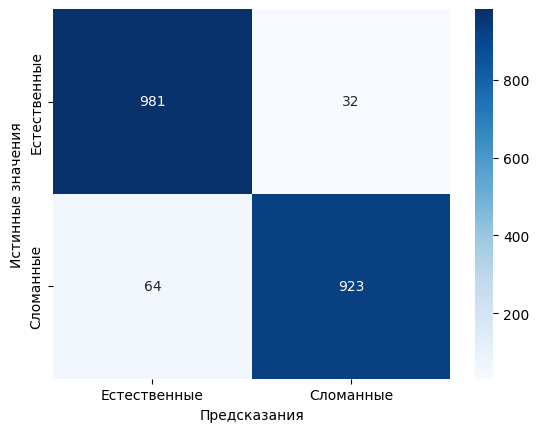

In [ ]:
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

print(f"Accuracy: {accuracy_score(val_labels, pred_labels):.3f}")
print(f"F1: {f1_score(val_labels, pred_labels):.3f}")
print(f"Precision: {precision_score(val_labels, pred_labels):.3f}")
print(f"Recall: {recall_score(val_labels, pred_labels):.3f}")

cm = confusion_matrix(val_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Естественные', 'Сломанные'],
            yticklabels=['Естественные', 'Сломанные'])
plt.xlabel('Предсказания')
plt.ylabel('Истинные значения')
plt.show()